In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from scipy.stats import shapiro
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [126]:
#Processing the dataframe and dropping NaN rows
def age_category(age):
  if age < 10:
    return 0
  elif age > 9 and age < 16:
    return 1
  elif age < 20:
    return 2
  elif age < 25:
    return 3
  elif age < 35:
    return 4
  elif age < 45:
    return 5
  elif age < 55:
    return 6
  elif age < 65:
    return 7
  elif age < 75:
    return 8
  elif age > 74:
    return 9

age_type = CategoricalDtype(categories=[0,1,2,3,4,5,6,7,8,9], ordered=True)
d = pd.read_csv("habits.data", sep=";", na_values="?")

d.kohde = pd.to_numeric(d['kohde'], errors='coerce')
d.jasen = pd.to_numeric(d['jasen'], errors='coerce')
d.pvknro = d.pvknro.map({1:'weekday', 2:'weekend'})
d.pvknro = d.pvknro.astype('category')
d.sp = d.sp.map({1:'man', 2:'woman'})
d.sp = d.sp.astype('category')
d.ASALUE = d.ASALUE.map({1:'city', 2:'municipality', 3:'rural'})
d.ASALUE = d.ASALUE.astype('category')
d.IKAL1 = d.IKAL1.apply(age_category)
d.IKAL1 = d.IKAL1.astype(age_type)
d.A1 = pd.to_numeric(d['A1'], errors='coerce')
d.A2 = pd.to_numeric(d['A2'], errors='coerce')
d.A3 = pd.to_numeric(d['A3'], errors='coerce')
d.A4 = pd.to_numeric(d['A4'], errors='coerce')
d.A5 = d.A5.map({1:'yes', 2:'no'})
d.A5 = d.A5.astype('category')
d.rename(columns={'A1': 'working', 'A2': 'sleeping', 'A3': 'reading', 'A4': 'restaurant', 'A5': 'library'}, inplace=True)
print(d.dtypes)

print(d.isnull().sum())
print(d.shape)

d = d.dropna()
print(d.shape)

kohde            int64
jasen            int64
pvknro        category
sp            category
ASALUE        category
IKAL1         category
working        float64
sleeping       float64
reading        float64
restaurant     float64
library       category
dtype: object
kohde          0
jasen          0
pvknro         0
sp             0
ASALUE         0
IKAL1          0
working       85
sleeping      88
reading       94
restaurant    91
library       62
dtype: int64
(745, 11)
(584, 11)


In [127]:
#Characterizing the individuals and activities
for col in ['pvknro', 'sp', 'ASALUE', "IKAL1", 'library']:
  print(f"\n{col}:\n", d[col].value_counts(normalize=True).round(2))

print(d[['working', 'sleeping', 'reading', 'restaurant']].describe().round(2))
print(d[['working', 'sleeping', 'reading', 'restaurant']].median().round(2))


pvknro:
 pvknro
weekday    0.51
weekend    0.49
Name: proportion, dtype: float64

sp:
 sp
woman    0.53
man      0.47
Name: proportion, dtype: float64

ASALUE:
 ASALUE
city            0.62
rural           0.21
municipality    0.17
Name: proportion, dtype: float64

IKAL1:
 IKAL1
7    0.26
6    0.23
5    0.16
4    0.14
8    0.11
9    0.07
3    0.03
0    0.00
1    0.00
2    0.00
Name: proportion, dtype: float64

library:
 library
yes    0.7
no     0.3
Name: proportion, dtype: float64
       working  sleeping  reading  restaurant
count   584.00    584.00   584.00      584.00
mean    121.52    518.42    47.48       47.95
std     207.21     98.76    63.43       58.48
min       0.00     70.00     0.00        0.00
25%       0.00    460.00     0.00        0.00
50%       0.00    510.00    30.00        0.00
75%     212.50    580.00    70.50      100.00
max     760.00    900.00   474.00      240.00
working         0.0
sleeping      510.0
reading        30.0
restaurant      0.0
dtype: float64


based on these descriptive statistics the number of samples from weekdays and weekends are almost equal 51% weekday, 49% weekend. 
This is also true for the genders which are almost equally divided 53% women, 47% men.

Most of the people live in a city 62%, while the rest live in rural 21% and in municipalities 17%
Most people 49% fall into the age ranges of 7(55-64 Years) 26% and 6(45-54 Years) 23%. There are no people in the age ranges of 0 (<10 Years), 1(10-14 Years) and 2(15-19 Years)
Most people have visited the library within the past year 70%

The average time for the following activities of working, sleeping, reading and dining out are: 121.5 min, 518.4 min, 47.5 min, 47.9 min
The median time for the following activities of working, sleeping, reading and dining out are: 0 min, 510 min, 30 min, 0 min

The standard deviations of the activities are all large >58, which indicates that there are several quite different characters present in the data.

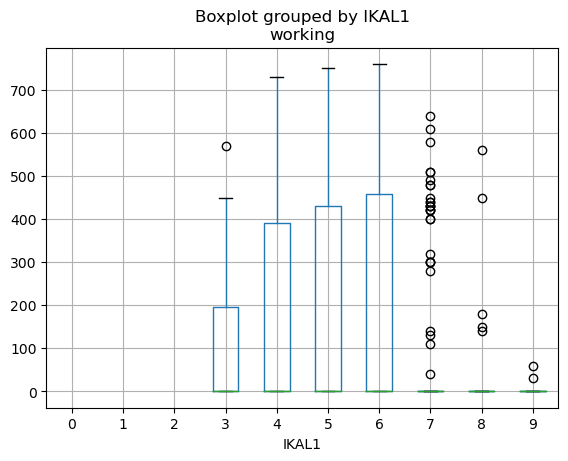

In [128]:
d.boxplot(column='working', by='IKAL1')
plt.show()

When using a boxplot that show the time of minutes spent working by the age group, it seems that there is a sharp drop in the number of minutes worked
between the groups 6 and 7. This indicates that the data is split into working people 46% and retired people 54%.

In [129]:
#The data suggests that processing the data by working people and not working people should yield better analysis results
d.loc[d['working'] >= 1, 'is_working'] = 'yes'
d.loc[d['working'] == 0, 'is_working'] = 'no'

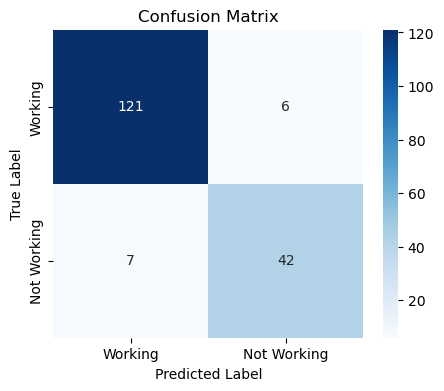

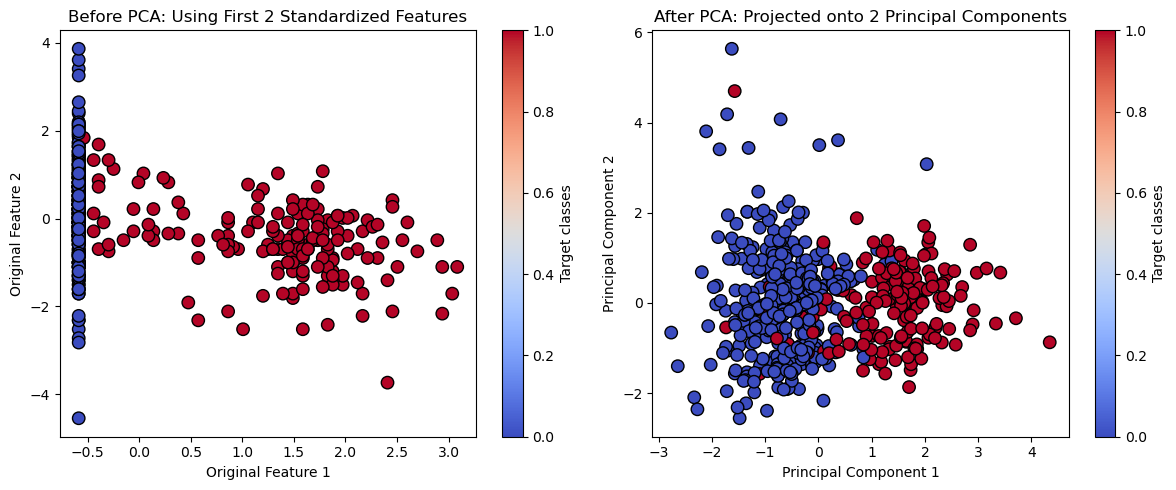

In [130]:
#PCA
columns = ['working', 'sleeping', 'reading', 'restaurant']
X = d.columns
y = d.is_working

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Working', 'Not Working'], yticklabels=['Working', 'Not Working'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

y_numeric = pd.factorize(y)[0]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_numeric, cmap='coolwarm', edgecolor='k', s=80)
plt.xlabel('Original Feature 1')
plt.ylabel('Original Feature 2')
plt.title('Before PCA: Using First 2 Standardized Features')
plt.colorbar(label='Target classes')

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_numeric, cmap='coolwarm', edgecolor='k', s=80)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('After PCA: Projected onto 2 Principal Components')
plt.colorbar(label='Target classes')

plt.tight_layout()
plt.show()

PCA also shows that there are two major groups in the data. People who work and people who don't work.

In [131]:
#Estimating how much time on average do Finnish household spend daily on each activity by their characterization as working or not working
print(f"Working\n {d.groupby(by=['is_working'], observed=False)['working'].mean()}")
print(f"Sleeping\n {d.groupby(by=['is_working'], observed=False)['sleeping'].mean()}")
print(f"Reading\n {d.groupby(by=['is_working'], observed=False)['reading'].mean()}")
print(f"Dining out\n{d.groupby(by=['is_working'], observed=False)['restaurant'].mean()}")
print(f"Visiting a library\n{d.groupby(by=['is_working'], observed=False)['library'].value_counts(normalize=True)}")

Working
 is_working
no       0.000000
yes    405.542857
Name: working, dtype: float64
Sleeping
 is_working
no     540.110024
yes    467.742857
Name: sleeping, dtype: float64
Reading
 is_working
no     55.960880
yes    27.651429
Name: reading, dtype: float64
Dining out
is_working
no     48.156479
yes    47.462857
Name: restaurant, dtype: float64
Visiting a library
is_working  library
no          yes        0.687042
            no         0.312958
yes         yes        0.725714
            no         0.274286
Name: proportion, dtype: float64


The average ammount of time for two types of households, working and not working, are:
Not working households:
Working:    0 min
Sleeping:   540 min
Reading:    56 min
Restaurant: 48 min
Library:    69% have visited during the past year

Working households:
Working:    406 min
Sleeping:   468 min
Reading:    28 min
Restaurant: 47 min
Library:    73% have visited during the past year

array([[<AxesSubplot: title={'center': 'working'}, xlabel='[ASALUE, is_working]'>,
        <AxesSubplot: title={'center': 'sleeping'}, xlabel='[ASALUE, is_working]'>],
       [<AxesSubplot: title={'center': 'reading'}, xlabel='[ASALUE, is_working]'>,
        <AxesSubplot: title={'center': 'restaurant'}, xlabel='[ASALUE, is_working]'>]],
      dtype=object)

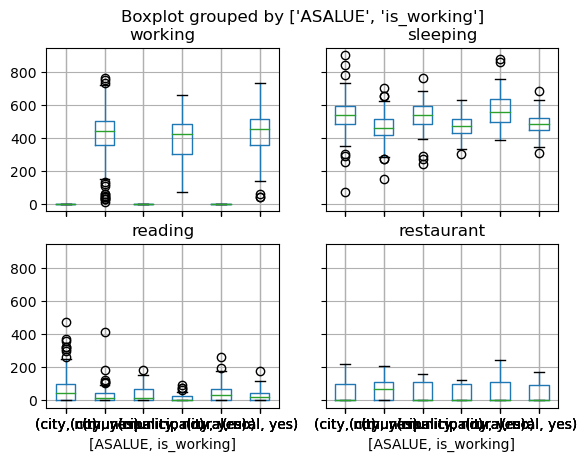

In [132]:
#With respect to which activities do living environments or days of weeks differ in Finland?
d.boxplot(column=['working','sleeping','reading','restaurant'], by=['ASALUE', 'is_working'])

array([[<AxesSubplot: title={'center': 'working'}, xlabel='[pvknro, is_working]'>,
        <AxesSubplot: title={'center': 'sleeping'}, xlabel='[pvknro, is_working]'>],
       [<AxesSubplot: title={'center': 'reading'}, xlabel='[pvknro, is_working]'>,
        <AxesSubplot: title={'center': 'restaurant'}, xlabel='[pvknro, is_working]'>]],
      dtype=object)

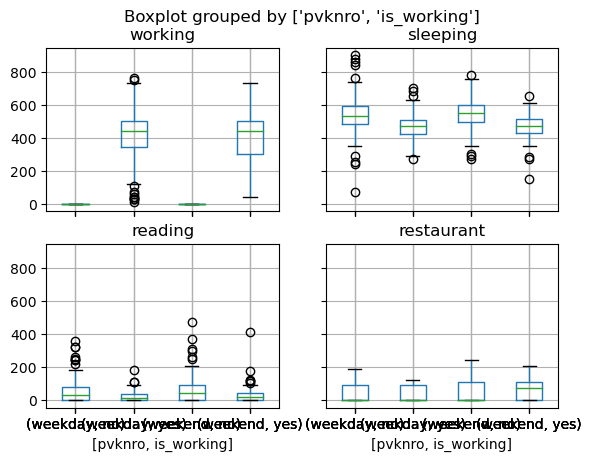

In [133]:
d.boxplot(column=['working','sleeping','reading','restaurant'], by=['pvknro', 'is_working'])

In [134]:
#Which activities are associated with each other in Finnish population
#Fist checking for normality to decide what statistical test is to be done to compare the correlation between the activities.
print(f"working\n{d.groupby(['is_working'])['working'].apply(shapiro)}")
print(f"sleeping\n{d.groupby(['is_working'])['sleeping'].apply(shapiro)}")
print(f"reading\n{d.groupby(['is_working'])['reading'].apply(shapiro)}")
print(f"eating out\n{d.groupby(['is_working'])['restaurant'].apply(shapiro)}")

working
is_working
no                                      (1.0, 1.0)
yes    (0.9363335967063904, 5.316215947459568e-07)
Name: working, dtype: object
sleeping
is_working
no     (0.9780734181404114, 7.467117939086165e-06)
yes     (0.9779261350631714, 0.006968495901674032)
Name: sleeping, dtype: object
reading
is_working
no     (0.7837207317352295, 6.756737541447078e-23)
yes    (0.6080691814422607, 8.364768301684166e-20)
Name: reading, dtype: object
eating out
is_working
no     (0.7513375282287598, 2.397319891974067e-24)
yes    (0.7642034888267517, 1.749887695073264e-15)
Name: restaurant, dtype: object


/usr/lib/python3/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [135]:
#There are no normally distributed varaibles so the statistical test for correlation is a Kruskal-Wallis test
#The tests are done for every combination of the four activities
print(mannwhitneyu(d.working, d.sleeping))
print(mannwhitneyu(d.working, d.reading))
print(mannwhitneyu(d.working, d.restaurant))
print(mannwhitneyu(d.sleeping, d.reading))
print(mannwhitneyu(d.sleeping, d.restaurant))
print(mannwhitneyu(d.reading, d.restaurant))

MannwhitneyuResult(statistic=28712.0, pvalue=1.3576389310774543e-139)
MannwhitneyuResult(statistic=140293.0, pvalue=1.3764524215105767e-08)
MannwhitneyuResult(statistic=166312.0, pvalue=0.39636068354159104)
MannwhitneyuResult(statistic=340511.5, pvalue=3.2309692693271947e-192)
MannwhitneyuResult(statistic=340792.0, pvalue=2.684627185014546e-196)
MannwhitneyuResult(statistic=180494.0, pvalue=0.06862401809262393)


There seems to be a correlation with: working and sleeping (p < 0.05) working and reading (p < 0.05) sleeping and reading (p < 0.05) sleeping and restaurant (p < 0.05)

Comparing sleeping with other activities might not be sensible, as everyone needs to sleep, and it doesn't reveal anyting new between the correlations of these activities. Without sleeping, the only correlation is with working and reading.